## testing stuff - starting with CSV flattening 

In [363]:
import pandas as pd
from pathlib import Path
import sys 
import gc
from tqdm.auto import tqdm 
import re
from string import punctuation
import matplotlib.pyplot as plt 
import seaborn as sns
import igraph as ig 
import ast
import orjson as json
import datetime as dt
import pyarrow.parquet as pq
import plotly.express as px
import plotly.io as pio

tqdm.pandas()
plt.rcParams.update({'font.size': 22})
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

pd.options.plotting.backend = 'plotly'
pio.templates.default = 'plotly_dark+presentation'

In [2]:
basepath = Path('/N/project/openalex/ssikdar/filtered')

For the whole dataset, run this cell

In [301]:
years = [2017, 2018, 2019, 2020, 2021, 2022]

dataset = pq.ParquetDataset(basepath / 'works_authorship_split', use_legacy_dataset=False,
                            filters=[('year', 'in', years),])

works_authors_df = dataset.read().to_pandas()

display(f'{len(works_authors_df)=:,}')
display(works_authors_df.head())

'len(works_authors_df)=137,068,709'

,work_id,author_id,author_name,institution_id,publication_date,year,month
3389,2286263278,3175442675,Jeffrey Brown,<NA>,2017-01-01,2017,1
3422,2286418227,2630270478,Nicole Coutrelis,<NA>,2017-01-01,2017,1
3423,2286418227,2342147013,Thomas Gourdea,<NA>,2017-01-01,2017,1
6467,2295757329,2157057934,Margaret Hodgins,<NA>,2017-01-01,2017,1
6468,2295757329,2778590059,Paul Fleming,<NA>,2017-01-01,2017,1


For the small snapshot, run the following instead

In [ ]:
works_authors_df = pd.read_parquet('')

In [347]:
# encapsulate in a function - rolling jaccard for an author_id 
def jaccard(list_of_lists):
    # if len(list_of_lists) == 1:
    #     return 0 
    
    list_of_sets = [set(l) for l in list_of_lists]
    intersection = set.intersection(*list_of_sets)
    union = set.union(*list_of_sets)

    return len(intersection) / max(1, len(union))

def rolling_iou_author(author_id, window_size=2, works_authors=small_works_authors_df):
    authors_works_df = (
        works_authors
        .query('author_id==@author_id')
        .sort_values(by='publication_date')
        .set_index('publication_date')
        .drop(columns=['year', 'month'])
    )
    
    author_work_ids = set(
        authors_works_df
        .work_id
        .unique()
    )
    
    # store the set of coauthors for each work id sorted by date 
    temporal_coauthors_df = authors_works_df.join(
        works_authors
        .query('work_id.isin(@author_work_ids)')
        .groupby('work_id')
        .author_id
        .apply(lambda x: list(set(x) - {author_id}))
        .rename('coauthors'),
        on='work_id'
    )

    res = (
        temporal_coauthors_df
        .assign(
            rolling_coauthors=lambda df_: ([
                window.to_list()
                for window in df_.coauthors.rolling(window=window_size)]),   # use monthly rolling?
            rolling_jaccard=lambda df_: df_.rolling_coauthors.apply(jaccard),
            window_size=window_size
        )
    )
    return res

In [330]:
author_ids = [2122189410, 2113839928, 2127131468, 2037649753]

In [349]:
combined_df = None

In [350]:
combined_df2 = None

In [351]:
rolling_window_size = 5

if combined_df is None:
    combined_df = (
        pd.concat([
        rolling_iou_author(author_id=aid, works_authors=works_authors_df, window_size=rolling_window_size)
        for aid in tqdm(author_ids)])
        .sort_index()
    )
else:
    new_aids = [aid for aid in author_ids if aid not in set(combined_df.author_id)]
    new_dfs = [rolling_iou_author(author_id=aid, works_authors=works_authors_df, window_size=rolling_window_size)
                for aid in tqdm(new_aids)]
    combined_df = (
        pd.concat([combined_df, *new_dfs])
    ).sort_index()
combined_df

  0%|          | 0/4 [00:00<?, ?it/s]

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,rolling_jaccard,window_size
publication_date,,,,,,,,
2017-01-01,2597768936,2113839928,Carlo Ratti,<NA>,[2303729449],[[2303729449]],1.000000,5
2017-01-01,2743414500,2113839928,Carlo Ratti,<NA>,"[2342688999, 2164998664, 2032565163, 212713146...","[[2303729449], [3031885824, 2746258369, 302906...",0.000000,5
2017-01-01,2754261237,2113839928,Carlo Ratti,63966007,"[2127131468, 1270670167, 2121986678, 2490743655]","[[2303729449], [3031885824, 2746258369, 302906...",0.000000,5
2017-01-01,2764360978,2127131468,Paolo Santi,63966007,"[2155208067, 2098713349, 2196641131, 256814961...","[[2342688999, 2164998664, 2032565163, 21138399...",0.066667,5
2017-01-01,2754261237,2127131468,Paolo Santi,63966007,"[2113839928, 1270670167, 2121986678, 2490743655]","[[2342688999, 2164998664, 2032565163, 21138399...",0.111111,5
...,...,...,...,...,...,...,...,...
2022-05-13,3204399149,2122189410,Santo Fortunato,<NA>,"[2793809274, 2469326107, 115369229, 2505591981]","[[2000084066, 3093826758, 2604826445, 30940716...",0.000000,5
2022-05-17,4280593352,2127131468,Paolo Santi,63966007,"[4280714948, 4280714949]","[[3215420100, 2152357223, 2095630856, 26511244...",0.000000,5
2022-05-17,4280593352,2127131468,Paolo Santi,4210130157,"[4280714948, 4280714949]","[[2306505153, 2152357223, 2571495213, 25872663...",0.000000,5


In [358]:
(
    combined_df
    .query('rolling_jaccard>0')
)

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,rolling_jaccard,window_size
publication_date,,,,,,,,
2017-01-01,2597768936,2113839928,Carlo Ratti,<NA>,[2303729449],[[2303729449]],1.000000,5
2017-01-01,2764360978,2127131468,Paolo Santi,63966007,"[2155208067, 2098713349, 2196641131, 256814961...","[[2342688999, 2164998664, 2032565163, 21138399...",0.066667,5
2017-01-01,2754261237,2127131468,Paolo Santi,63966007,"[2113839928, 1270670167, 2121986678, 2490743655]","[[2342688999, 2164998664, 2032565163, 21138399...",0.111111,5
2017-01-01,2743414500,2127131468,Paolo Santi,<NA>,"[2342688999, 2164998664, 2032565163, 211383992...","[[2342688999, 2164998664, 2032565163, 21138399...",1.000000,5
2017-02-04,2963503534,2037649753,Tim Weninger,107639228,[2222650814],[[2222650814]],1.000000,5
2017-03-01,2559662652,2037649753,Tim Weninger,107639228,"[2222650814, 3157462175]","[[2222650814], [2222650814, 3157462175]]",0.500000,5
2017-04-01,2604374094,2122189410,Santo Fortunato,<NA>,"[2156931689, 2105367364, 2037037628, 2074066684]","[[2156931689, 2105367364, 2037037628, 20740666...",1.000000,5
2018-11-01,2964215131,2037649753,Tim Weninger,107639228,"[3205281731, 2020459140, 2229551975]","[[2170978862, 2229551975], [2170978862, 222955...",0.250000,5
2018-11-21,3102739576,2037649753,Tim Weninger,107639228,"[2170978862, 2229551975]","[[2170978862, 2229551975], [2170978862, 222955...",0.250000,5


In [354]:
rolling_window_size = '365D'
combined_df2 = None 
if combined_df2 is None:
    combined_df2 = (
        pd.concat([
        rolling_iou_author(author_id=aid, works_authors=works_authors_df, window_size=rolling_window_size)
        for aid in tqdm(author_ids)])
        .sort_index()
    )
else:
    new_aids = [aid for aid in author_ids if aid not in set(combined_df2.author_id)]
    new_dfs = [rolling_iou_author(author_id=aid, works_authors=works_authors_df, window_size=rolling_window_size)
                for aid in tqdm(new_aids)]
    combined_df2 = (
        pd.concat([combined_df2, *new_dfs])
    ).sort_index()
combined_df2

  0%|          | 0/4 [00:00<?, ?it/s]

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,rolling_jaccard,window_size
publication_date,,,,,,,,
2017-01-01,2597768936,2113839928,Carlo Ratti,<NA>,[2303729449],[[2303729449]],1.000000,365D
2017-01-01,2743414500,2113839928,Carlo Ratti,<NA>,"[2342688999, 2164998664, 2032565163, 212713146...","[[2303729449], [3031885824, 2746258369, 302906...",0.000000,365D
2017-01-01,2754261237,2113839928,Carlo Ratti,63966007,"[2127131468, 1270670167, 2121986678, 2490743655]","[[2303729449], [3031885824, 2746258369, 302906...",0.000000,365D
2017-01-01,2764360978,2127131468,Paolo Santi,63966007,"[2155208067, 2098713349, 2196641131, 256814961...","[[2342688999, 2164998664, 2032565163, 21138399...",0.066667,365D
2017-01-01,2754261237,2127131468,Paolo Santi,63966007,"[2113839928, 1270670167, 2121986678, 2490743655]","[[2342688999, 2164998664, 2032565163, 21138399...",0.111111,365D
...,...,...,...,...,...,...,...,...
2022-05-13,3204399149,2122189410,Santo Fortunato,<NA>,"[2793809274, 2469326107, 115369229, 2505591981]","[[2248192384, 2148494662, 2980714778, 84223386...",0.100000,365D
2022-05-17,4280593352,2127131468,Paolo Santi,63966007,"[4280714948, 4280714949]","[[2184855622, 2490743655, 2164998664, 21137864...",0.000000,365D
2022-05-17,4280593352,2127131468,Paolo Santi,4210130157,"[4280714948, 4280714949]","[[2184855622, 2490743655, 2164998664, 21137864...",0.000000,365D


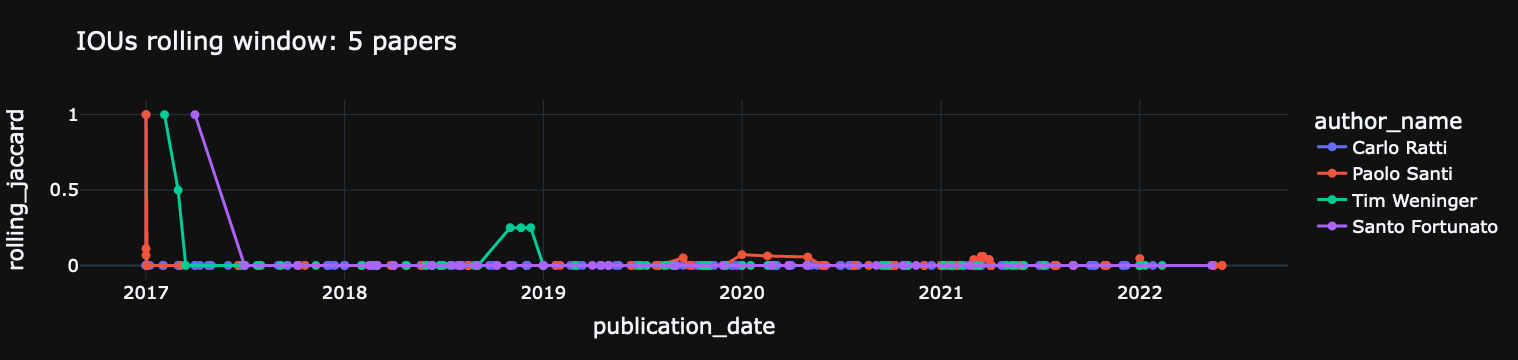

In [362]:
window = f'{combined_df.window_size.values[0]} papers'
(
    combined_df
    # .groupby(pd.Grouper(freq='1D'))
    # .agg(author_name=pd.NamedAgg(column='author_name', aggfunc='first'),
    #      rolling_iou=pd.NamedAgg(column='rolling_jaccard', aggfunc='mean'))
    # .dropna(subset=['rolling_iou'])
    # .rename(columns={'rolling_iou': 'Rolling IOU'})
    .plot
    .line(y='rolling_jaccard', color='author_name', markers=True, 
          title=f'IOUs rolling window: {window}')
)

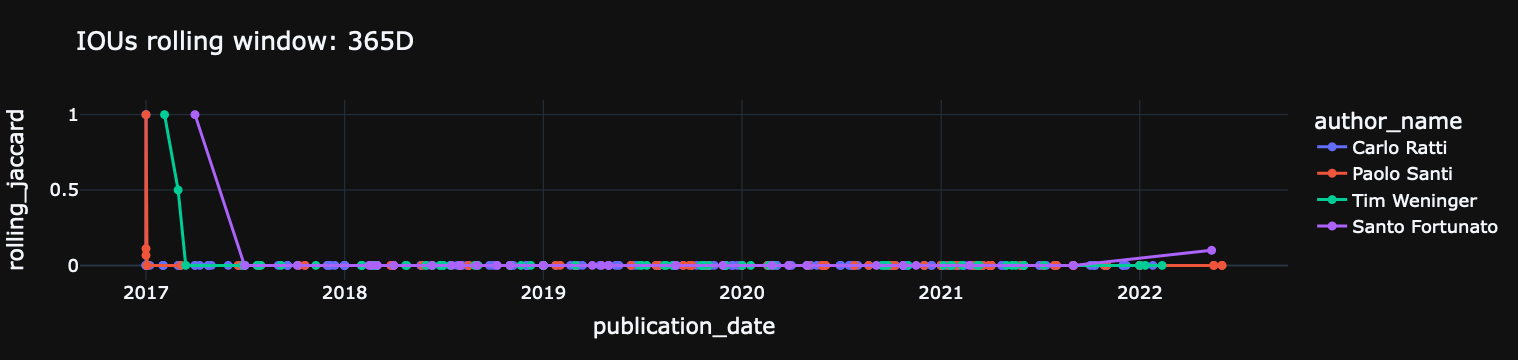

In [361]:
window = combined_df2.window_size.values[0]
(
    combined_df2
    # .groupby(pd.Grouper(freq='1D'))
    # .agg(author_name=pd.NamedAgg(column='author_name', aggfunc='first'),
    #      rolling_iou=pd.NamedAgg(column='rolling_jaccard', aggfunc='mean'))
    # .dropna(subset=['rolling_iou'])
    # .rename(columns={'rolling_iou': 'Rolling IOU'})
    .plot
    .line(y='rolling_jaccard', color='author_name', markers=True, 
          title=f'IOUs rolling window: {window}')
)

In [314]:
(
    combined_df2
    .query('author_name=="Santo Fortunato"')
    .query('rolling_jaccard>0')
)

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,rolling_jaccard,window_size
publication_date,,,,,,,,
2017-10-06,2761435952,2122189410,Santo Fortunato,<NA>,"[1274808907, 2257442005]","[[2949512033, 2395754243, 3210888771, 22387040...",0.076923,180D
2018-02-15,3121329986,2122189410,Santo Fortunato,<NA>,"[2157809153, 2952575497, 2025463562, 216398695...","[[1274808907, 2257442005], [2157809153, 295257...",0.010000,180D
2018-02-19,2963041679,2122189410,Santo Fortunato,592451,"[1274808907, 2257442005]","[[1274808907, 2257442005], [2157809153, 295257...",0.010000,180D


In [315]:
(
    combined_df2
    .query('author_name=="Tim Weninger"')
    .loc['2020': '2020-09']
)

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,rolling_jaccard,window_size
publication_date,,,,,,,,
2020-01-01,3173804767,2037649753,Tim Weninger,107639228,"[2999961928, 3000004337, 2746653655, 279316447...","[[2947576465, 2746653655], [2297758725, 296882...",0.0,180D
2020-01-17,3000690722,2037649753,Tim Weninger,107639228,"[2999961928, 3000004337, 2746653655, 279316447...","[[2297758725, 2968829366], [2014907840, 224819...",0.0,180D
2020-02-19,3007996372,2037649753,Tim Weninger,<NA>,"[3008716992, 2082382046]","[[2947576465, 2746653655], [2297758725, 296882...",0.0,180D
2020-02-28,3008221414,2037649753,Tim Weninger,107639228,"[2947576465, 2746653655]","[[2297758725, 2968829366], [2947576465], [2222...",0.0,180D
2020-09-14,3084934683,2037649753,Tim Weninger,107639228,"[2968829366, 2297758725, 3086190262]","[[2968829366, 2297758725, 3086190262]]",0.0,180D
2020-09-18,3087679241,2037649753,Tim Weninger,107639228,"[2297758725, 3086190262, 3087140631]","[[2968829366, 2297758725, 3086190262], [229775...",0.5,180D
2020-09-25,3091314601,2037649753,Tim Weninger,107639228,"[2787316701, 3091203919]","[[2968829366, 2297758725, 3086190262], [229775...",0.0,180D


In [322]:
(
    combined_df
    .query('author_name=="Tim Weninger"')
    .loc['2018']
)

,work_id,author_id,author_name,institution_id,coauthors,rolling_coauthors,rolling_jaccard,window_size
publication_date,,,,,,,,
2018-02-01,2750171493,2037649753,Tim Weninger,107639228,"[2110072997, 2157503142, 2629702310, 211829905...","[[2229551975], [2229551975], [2082264248, 2229...",0.00,5
2018-02-02,2787896276,2037649753,Tim Weninger,107639228,"[2167285659, 2131539564, 2158342695]","[[2229551975], [2082264248, 2229551975], [2222...",0.00,5
2018-02-21,2788570566,2037649753,Tim Weninger,107639228,"[2084141825, 2297564775]","[[2082264248, 2229551975], [2222650814], [2110...",0.00,5
2018-02-23,2788260867,2037649753,Tim Weninger,107639228,[2222650814],"[[2222650814], [2110072997, 2157503142, 262970...",0.00,5
2018-03-01,3125265912,2037649753,Tim Weninger,107639228,"[2791827785, 2179590732, 319400591]","[[2110072997, 2157503142, 2629702310, 21182990...",0.00,5
2018-03-01,2791945349,2037649753,Tim Weninger,107639228,"[2791827785, 2179590732, 319400591]","[[2167285659, 2131539564, 2158342695], [208414...",0.00,5
2018-04-23,3101273361,2037649753,Tim Weninger,107639228,[2222650814],"[[2084141825, 2297564775], [2222650814], [2791...",0.00,5
2018-04-25,2963041663,2037649753,Tim Weninger,107639228,[2222650814],"[[2222650814], [2791827785, 2179590732, 319400...",0.00,5
2018-05-30,2949112265,2037649753,Tim Weninger,107639228,"[2170978862, 2229551975]","[[2791827785, 2179590732, 319400591], [2791827...",0.00,5
